# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle
import os

# Load and Save Data
- 640 total examples
- 270/370 - train/test split
- 9 speakers total
- each sample is a timeseries of a varying length in the range of 7 to 29
- each point of the time series has 12 features - the coefficients
- in the training set each speaker has 30 recording blocks
- in the test set each speaker has the following number of vowel recording blocks: [31 35 88 44 29 24 40 50 29] 

Note: I verified that the matlab code and the code below produce identical results

In [2]:
def load_ae_data(train_file='data\\ae.train', test_file='data\\ae.test'):
    """
    Load and parse the ape call data from ASCII files.
    
    Returns:
    - train_inputs: list of numpy arrays (270 time series, each N x 12)
    - test_inputs: list of numpy arrays (370 time series, each N x 12) 
    - train_outputs: list of numpy arrays (270 time series, each N x 9)
    - test_outputs: list of numpy arrays (370 time series, each N x 9)
    - N is the length of the time series, varying per sample
    """
    
    # Load the data
    ae_train = np.loadtxt(train_file)
    ae_test = np.loadtxt(test_file)
    
    # Parse training data
    train_inputs = []
    read_index = 0
    
    for c in range(270):
        start_index = read_index
        # Find the length of current time series (until we hit a row of 1.0s)
        while read_index < len(ae_train) and ae_train[read_index, 0] != 1.0:
            read_index += 1
        
        # Extract the time series
        time_series = ae_train[start_index:read_index, :]
        train_inputs.append(time_series)
        
        # Skip the separator row of 1.0s
        read_index += 1
    
    # Parse test data
    test_inputs = []
    read_index = 0
    
    for c in range(370):
        start_index = read_index
        # Find the length of current time series
        while read_index < len(ae_test) and ae_test[read_index, 0] != 1.0:
            read_index += 1
        
        # Extract the time series
        time_series = ae_test[start_index:read_index, :]
        test_inputs.append(time_series)
        
        # Skip the separator row of 1.0s
        read_index += 1
    
    # Generate teacher signals (outputs)
    train_outputs = []
    for c in range(270):
        length = len(train_inputs[c])
        teacher = np.zeros((length, 9))
        speaker_index = c // 30  # 30 samples per speaker, 9 speakers total
        teacher[:, speaker_index] = 1
        train_outputs.append(teacher)
    
    test_outputs = []
    speaker_index = 0
    block_counter = 0
    block_lengths = [31, 35, 88, 44, 29, 24, 40, 50, 29]  # samples per speaker in test set
    
    for c in range(370):
        if block_counter == block_lengths[speaker_index]:
            speaker_index += 1
            block_counter = 0
        
        length = len(test_inputs[c])
        teacher = np.zeros((length, 9))
        teacher[:, speaker_index] = 1
        test_outputs.append(teacher)
        
        block_counter += 1
    
    return train_inputs, test_inputs, train_outputs, test_outputs

## Save 

In [3]:
# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Load the data
train_inputs, test_inputs, train_outputs, test_outputs = load_ae_data()

# Save the data as separate pickle files
with open('data/train_inputs.pkl', 'wb') as f:
    pickle.dump(train_inputs, f)
with open('data/test_inputs.pkl', 'wb') as f:
    pickle.dump(test_inputs, f)
with open('data/train_outputs.pkl', 'wb') as f:
    pickle.dump(train_outputs, f)
with open('data/test_outputs.pkl', 'wb') as f:
    pickle.dump(test_outputs, f)

## Example loading saved data

In [4]:
def load_saved_data(data_folder='data'):
    """
    Load the preprocessed ape call data from pickle files.
    
    Args:
        data_folder (str): Path to the folder containing pickle files
        
    Returns:
        tuple: (train_inputs, test_inputs, train_outputs, test_outputs)
    """
    try:
        with open(f'{data_folder}/train_inputs.pkl', 'rb') as f:
            train_inputs = pickle.load(f)
        with open(f'{data_folder}/test_inputs.pkl', 'rb') as f:
            test_inputs = pickle.load(f)
        with open(f'{data_folder}/train_outputs.pkl', 'rb') as f:
            train_outputs = pickle.load(f)
        with open(f'{data_folder}/test_outputs.pkl', 'rb') as f:
            test_outputs = pickle.load(f)
        
        print(f"Data loaded successfully from {data_folder}/")
        print(f"Train samples: {len(train_inputs)}, Test samples: {len(test_inputs)}")
        print(f"Input dimensions: {train_inputs[0].shape[1]}, Output dimensions: {train_outputs[0].shape[1]}")
        
        return train_inputs, test_inputs, train_outputs, test_outputs
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None, None, None, None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None, None

In [5]:
# Example usage for other notebooks:
train_inputs, test_inputs, train_outputs, test_outputs = load_saved_data()

Data loaded successfully from data/
Train samples: 270, Test samples: 370
Input dimensions: 12, Output dimensions: 9


# EDA

- Just some quick prints to get familiar with the data

In [6]:
# Display data shapes and statistics
print("=== SANITY CHECK ===")
print(f"Number of training time series: {len(train_inputs)}")
print(f"Number of test time series: {len(test_inputs)}")
print(f"Input dimensionality: {train_inputs[0].shape[1]}")
print(f"Output dimensionality: {train_outputs[0].shape[1]}")

print("\n=== TRAINING DATA ===")
train_lengths = [ts.shape[0] for ts in train_inputs]
print(f"Time series lengths - Min: {min(train_lengths)}, Max: {max(train_lengths)}, Mean: {np.mean(train_lengths):.1f}")

print("\n=== TEST DATA ===")
test_lengths = [ts.shape[0] for ts in test_inputs]
print(f"Time series lengths - Min: {min(test_lengths)}, Max: {max(test_lengths)}, Mean: {np.mean(test_lengths):.1f}")

print("\n=== AVG TRAIN SAMPLE LENGTH PER SPEAKER ===")
print("Training data (30 samples per speaker):")
for speaker in range(9):
    start_idx = speaker * 30
    end_idx = (speaker + 1) * 30
    speaker_lengths = [len(train_inputs[i]) for i in range(start_idx, end_idx)]
    print(f"Speaker {speaker + 1}: {len(speaker_lengths)} samples, avg length: {np.mean(speaker_lengths):.1f}")


print("\n=== SAMPLE DATA SHAPES ===")
print("First 5 training samples:")
for i in range(5):
    print(f"Sample {i+1}: Input {train_inputs[i].shape}, Output {train_outputs[i].shape}")

print("\nFirst 5 test samples:")
for i in range(5):
    print(f"Sample {i+1}: Input {test_inputs[i].shape}, Output {test_outputs[i].shape}")

# Display sample data values
print("\n=== SAMPLE INPUT VALUES ===")
print("First training sample (first 5 time steps):")
print(train_inputs[0][:5])

print("\nCorresponding output (first 5 time steps):")
print(train_outputs[0][:5])

=== SANITY CHECK ===
Number of training time series: 270
Number of test time series: 370
Input dimensionality: 12
Output dimensionality: 9

=== TRAINING DATA ===
Time series lengths - Min: 7, Max: 26, Mean: 15.8

=== TEST DATA ===
Time series lengths - Min: 7, Max: 29, Mean: 15.4

=== AVG TRAIN SAMPLE LENGTH PER SPEAKER ===
Training data (30 samples per speaker):
Speaker 1: 30 samples, avg length: 18.1
Speaker 2: 30 samples, avg length: 15.5
Speaker 3: 30 samples, avg length: 14.1
Speaker 4: 30 samples, avg length: 20.2
Speaker 5: 30 samples, avg length: 13.2
Speaker 6: 30 samples, avg length: 17.4
Speaker 7: 30 samples, avg length: 16.9
Speaker 8: 30 samples, avg length: 12.6
Speaker 9: 30 samples, avg length: 14.5

=== SAMPLE DATA SHAPES ===
First 5 training samples:
Sample 1: Input (20, 12), Output (20, 9)
Sample 2: Input (26, 12), Output (26, 9)
Sample 3: Input (22, 12), Output (22, 9)
Sample 4: Input (20, 12), Output (20, 9)
Sample 5: Input (21, 12), Output (21, 9)

First 5 test s

- we see that some speakers on average have shorter sequence lengths compared to others.

## Distriubtion of lengths

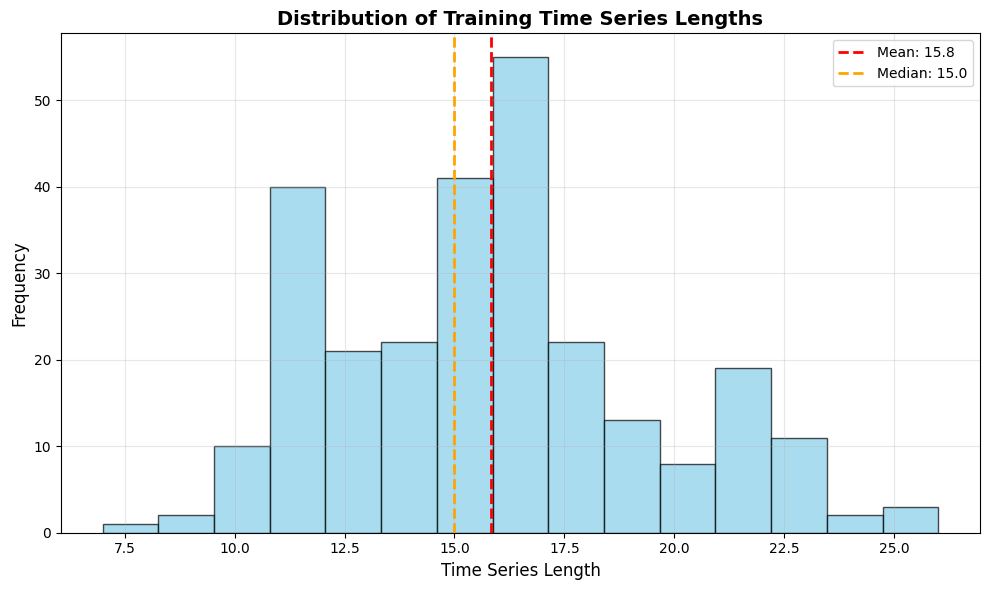

Training time series length statistics:
Min: 7, Max: 26
Mean: 15.8, Median: 15.0
Standard deviation: 3.6


In [7]:
# Visualization of training time series lengths
plt.figure(figsize=(10, 6))
train_lengths = [ts.shape[0] for ts in train_inputs]

plt.hist(train_lengths, bins=15, alpha=0.7, edgecolor='black', color='skyblue')
plt.title('Distribution of Training Time Series Lengths', fontsize=14, fontweight='bold')
plt.xlabel('Time Series Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)

# Add some statistics as text
mean_length = np.mean(train_lengths)
median_length = np.median(train_lengths)
plt.axvline(mean_length, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_length:.1f}')
plt.axvline(median_length, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_length:.1f}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Training time series length statistics:")
print(f"Min: {min(train_lengths)}, Max: {max(train_lengths)}")
print(f"Mean: {mean_length:.1f}, Median: {median_length:.1f}")
print(f"Standard deviation: {np.std(train_lengths):.1f}")

## Visualize all 12 dim

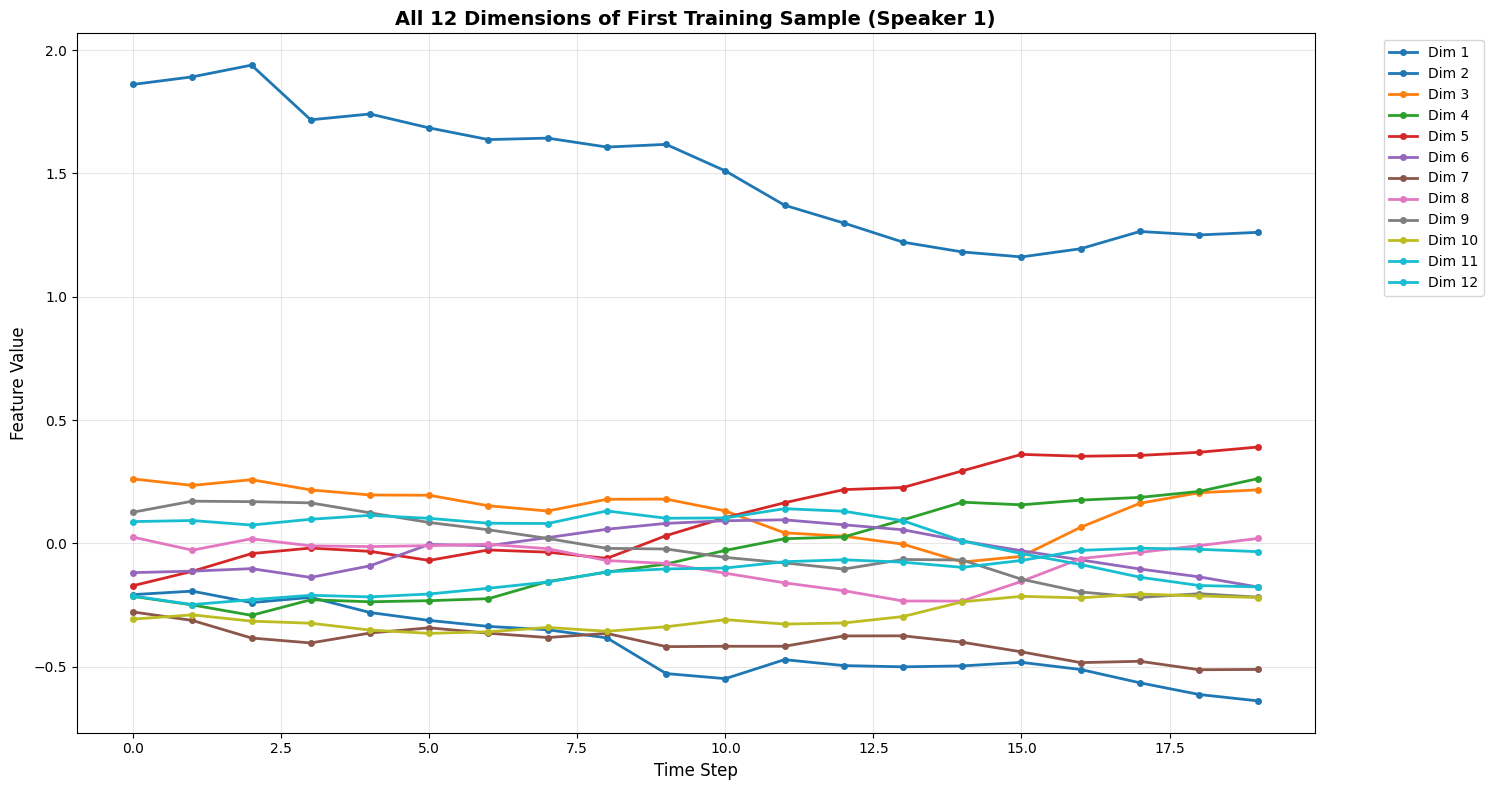

First training sample info:
Shape: (20, 12)
Speaker: 1
Length: 20 time steps
Feature value ranges:
  Dim 1: [1.162, 1.939]
  Dim 2: [-0.638, -0.193]
  Dim 3: [-0.075, 0.262]
  Dim 4: [-0.291, 0.263]
  Dim 5: [-0.171, 0.391]
  Dim 6: [-0.177, 0.096]
  Dim 7: [-0.512, -0.278]
  Dim 8: [-0.234, 0.026]
  Dim 9: [-0.219, 0.171]
  Dim 10: [-0.364, -0.205]
  Dim 11: [-0.248, -0.019]
  Dim 12: [-0.176, 0.141]


In [8]:
# Visualization of all 12 dimensions for the first training sample
plt.figure(figsize=(15, 8))

# Get the first training sample
sample_data = train_inputs[0]
time_steps = range(len(sample_data))

# Define colors for each dimension
colors = plt.cm.tab10(np.linspace(0, 1, 12))

# Plot all 12 dimensions
for dim in range(12):
    plt.plot(time_steps, sample_data[:, dim], 
             color=colors[dim], 
             linewidth=2, 
             marker='o', 
             markersize=4,
             label=f'Dim {dim + 1}')

plt.title('All 12 Dimensions of First Training Sample (Speaker 1)', fontsize=14, fontweight='bold')
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Feature Value', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"First training sample info:")
print(f"Shape: {sample_data.shape}")
print(f"Speaker: {np.argmax(train_outputs[0][0]) + 1}")
print(f"Length: {len(sample_data)} time steps")
print(f"Feature value ranges:")
for dim in range(12):
    min_val = np.min(sample_data[:, dim])
    max_val = np.max(sample_data[:, dim])
    print(f"  Dim {dim + 1}: [{min_val:.3f}, {max_val:.3f}]")

## Distriubtion per speaker and dimension
- Are there any clearly distinct patterns in speaker coefficient distributions?

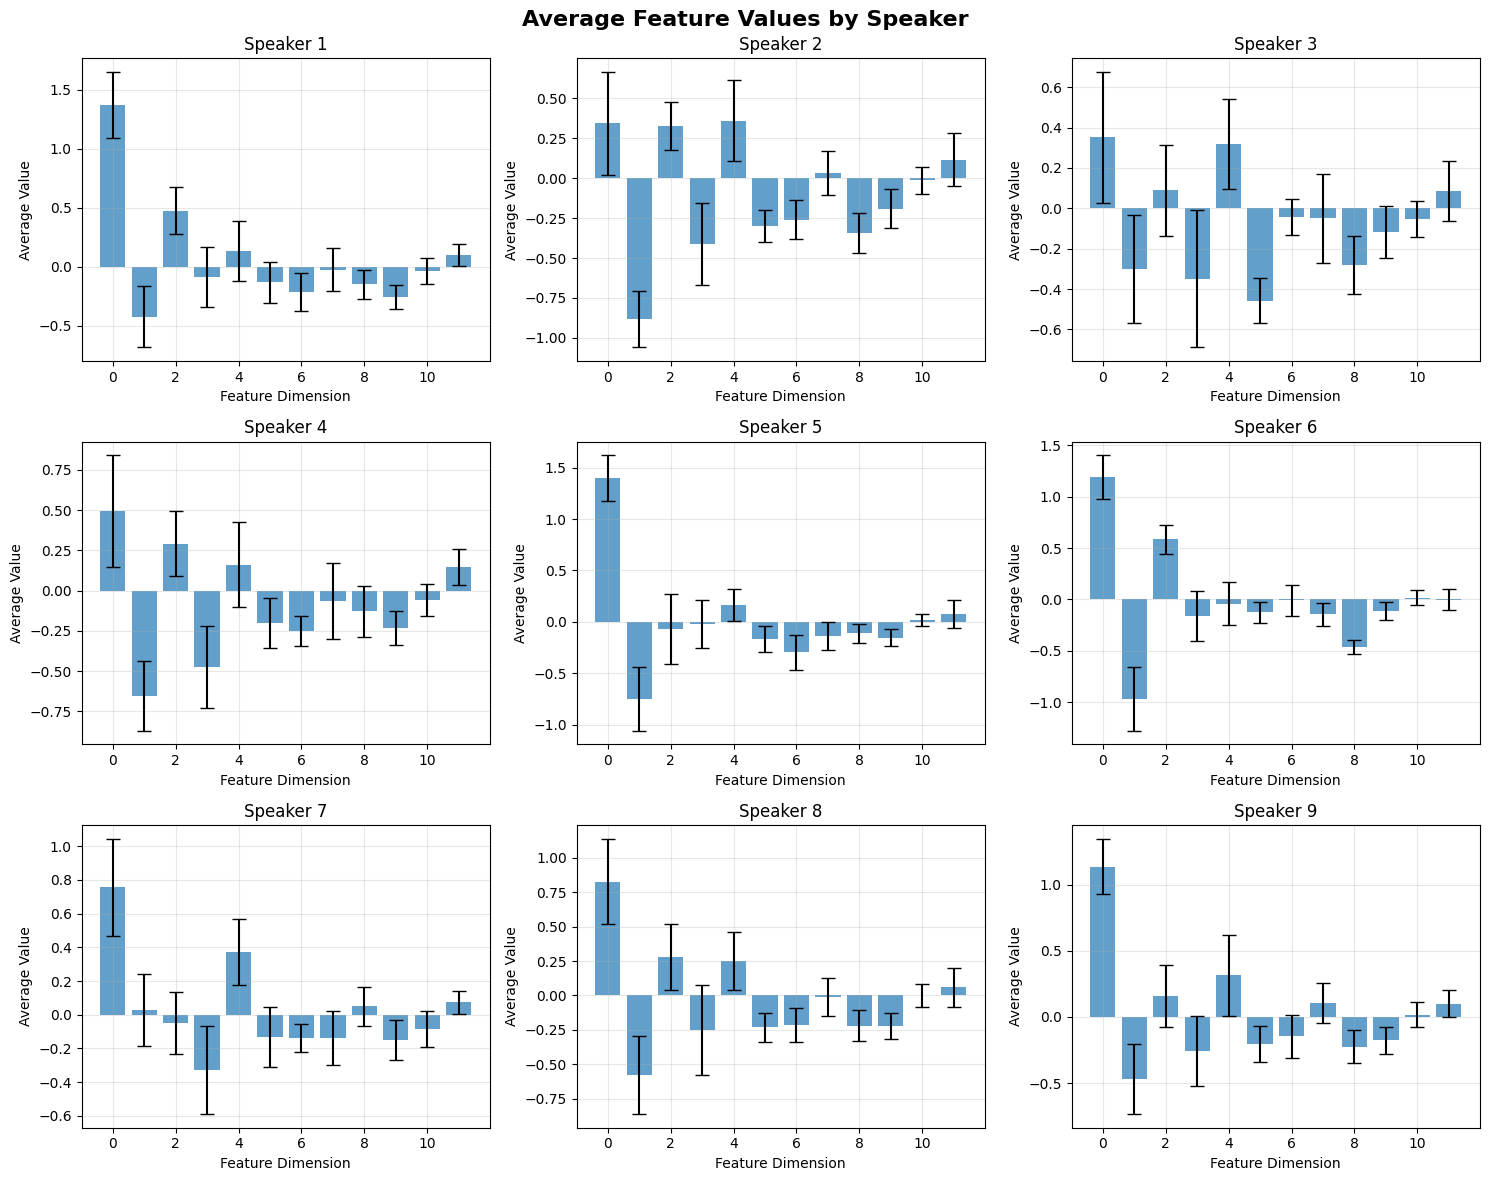

In [9]:
# Speaker-specific analysis - feature distributions per speaker
def analyze_speaker_features():
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle('Average Feature Values by Speaker', fontsize=16, fontweight='bold')
    
    speaker_means = []
    speaker_stds = []
    
    for speaker in range(9):
        # Get all samples for this speaker
        start_idx = speaker * 30
        end_idx = (speaker + 1) * 30
        speaker_data = np.vstack([train_inputs[i] for i in range(start_idx, end_idx)])
        
        # Calculate mean and std for each dimension
        means = np.mean(speaker_data, axis=0)
        stds = np.std(speaker_data, axis=0)
        speaker_means.append(means)
        speaker_stds.append(stds)
        
        # Plot
        row, col = speaker // 3, speaker % 3
        axes[row, col].bar(range(12), means, yerr=stds, alpha=0.7, capsize=5)
        axes[row, col].set_title(f'Speaker {speaker + 1}')
        axes[row, col].set_xlabel('Feature Dimension')
        axes[row, col].set_ylabel('Average Value')
        axes[row, col].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return np.array(speaker_means), np.array(speaker_stds)

speaker_means, speaker_stds = analyze_speaker_features()

## Basic PCA Analysis

### Methodology
For each of the 270 training sequences, extracted simple statistical features:
- **Mean** of each of the 12 coefficients
- **Standard deviation** of each of the 12 coefficients  
- **Sequence length** 1 feature
- **Total**: 25 features per sequence

- Next scale these features and apply PCA for dimensionality reduction.

### Results
- The first two principal components (PC1 + PC2) explain about **31%** of the total variance
- While we can observe some clustering patterns by speaker in the 2D PCA plot, the relatively low variance capture means we cannot draw deep conclusions about speaker separability from this analysis alone


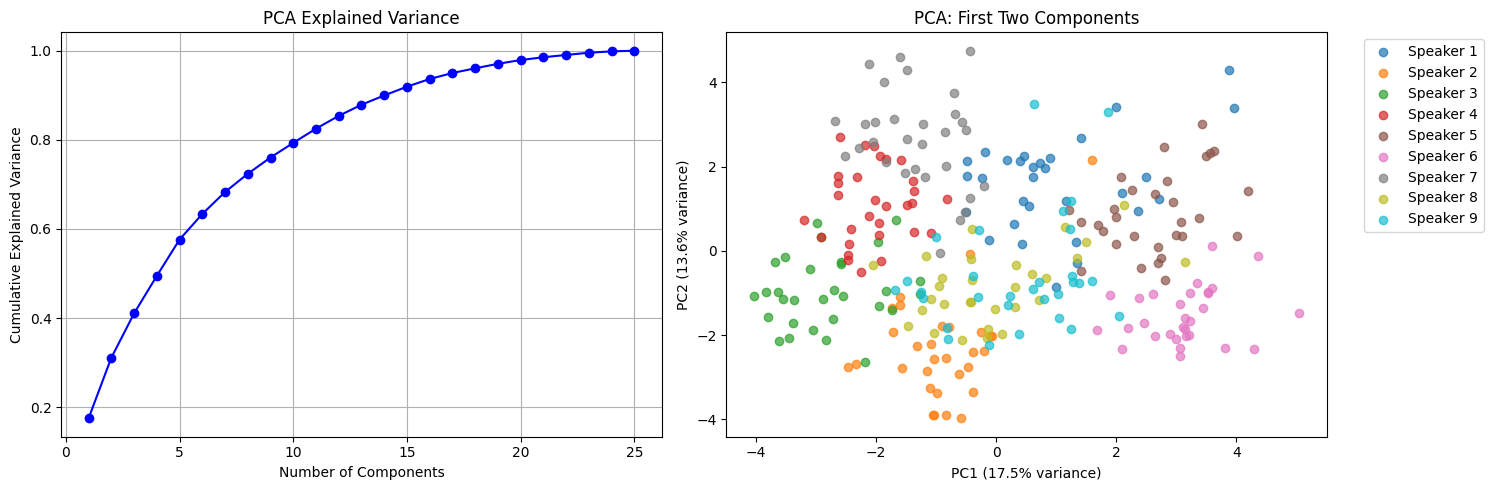

In [10]:
# Basci PCA analysis
def analyze_pca():
    feature_vectors = []
    speaker_labels = []
    
    for i, sample in enumerate(train_inputs):
        # Use statistical summaries as features
        mean_features = np.mean(sample, axis=0)
        std_features = np.std(sample, axis=0)
        sequence_length = len(sample)
        
        # Combine all features: 12 means + 12 stds + 1 length = 25 features
        combined_features = np.concatenate([mean_features, std_features, [sequence_length]])
        feature_vectors.append(combined_features)
        speaker_labels.append(i // 30)
    
    
    feature_vectors = np.array(feature_vectors)
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_vectors)
    
    # Apply PCA
    pca = PCA()
    pca_features = pca.fit_transform(scaled_features)
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Explained variance
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             np.cumsum(pca.explained_variance_ratio_), 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid(True)
    
    # 2D PCA plot
    plt.subplot(1, 2, 2)
    colors = plt.cm.tab10(np.linspace(0, 1, 9))
    for speaker in range(9):
        mask = np.array(speaker_labels) == speaker
        plt.scatter(pca_features[mask, 0], pca_features[mask, 1], 
                   c=[colors[speaker]], label=f'Speaker {speaker+1}', alpha=0.7)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.title('PCA: First Two Components')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    
    plt.tight_layout()
    plt.show()
    
analyze_pca()